# Machine Learning Tests on WWW

## Basic imports, setups

In [7]:
print("Have a great day!")
import os, time, sys
start_time = time.time()
import pandas as pd
import numpy as np
print("import sklearn")
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelBinarizer, scale
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
print("import matplotlib")
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
%matplotlib inline
print("import torch")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
print("import xgboost")
from tqdm import tqdm
from xgboost import XGBClassifier
import xgboost as xgb
print("import ROOT + others")
import ROOT
print("Fix random number generators")
np.random.seed(24)
torch.manual_seed(24)
print("--- %.2f seconds ---" % (time.time() - start_time))

Have a great day!
import sklearn
import matplotlib
import torch
import xgboost
import ROOT + others
Fix random number generators
--- 0.02 seconds ---


## Data and import

In [9]:
def get_data(data_dir):
    fs = [data_dir + f for f in os.listdir(data_dir) if ('signal' in f or 'bkg' in f) and f[0] != '.']
    df = pd.DataFrame()
    for f in fs:
        print("adding", f)
        new_df = pd.read_csv(f)
        df = pd.concat([df, new_df], ignore_index = True)
        df.index = range(len(df))
    print("done merging data")
    return df

def add_cl_ix(df):
    df['is_sig'] = [1 if 'signal' in val else 0 for val in df.cl.values]
    return df

In [10]:
data_dir = '../data/' # Modify this
df_all = get_data(data_dir)
df_all = add_cl_ix(df_all)

adding ../data/bkg_Gee.csv
adding ../data/bkg_Gmumu.csv
adding ../data/bkg_Gtautau.csv
adding ../data/bkg_WZlvll.csv
adding ../data/bkg_WZqqll.csv
adding ../data/bkg_Wtll.csv
adding ../data/bkg_Wtllat.csv
adding ../data/bkg_ZZllll.csv
adding ../data/bkg_ZZqqll.csv
adding ../data/bkg_ZZvvll.csv
adding ../data/bkg_Zee.csv
adding ../data/bkg_Zmumu.csv
adding ../data/bkg_Ztautau.csv
adding ../data/bkg_stl.csv
adding ../data/bkg_stlat.csv
adding ../data/bkg_ttW0.csv
adding ../data/bkg_ttW1.csv
adding ../data/bkg_ttW2.csv
adding ../data/bkg_ttZ0.csv
adding ../data/bkg_ttZ1.csv
adding ../data/bkg_ttll.csv
adding ../data/signal_WmWpWm.csv
adding ../data/signal_WpWpWm.csv
done merging data


#### Set the explicit flavor

In [11]:
## copy into 3 different dfs
df_0 = df_all[df_all.SFOS == 0]
df_1 = df_all[df_all.SFOS == 1]
df_2 = df_all[df_all.SFOS == 2]

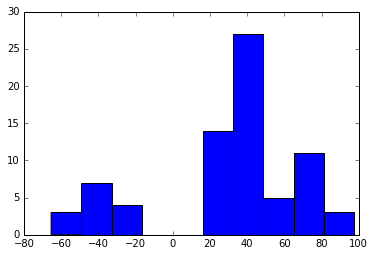

/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [29]:
## quick check
#print(df_all.head())
plt.clf()
#print(df_all.loc[abs(df_all.weight) > 20, 'cl'])
plt.hist(df_all.loc[abs(df_all.weight) > 20, 'weight'])
plt.show()

##quick clean
df_0.loc[abs(df_0.weight) > 10, 'weight'] = 0
df_0.loc[abs(df_0.weight) > 10, 'weight'] = 0
df_0.loc[abs(df_0.weight) > 10, 'weight'] = 0

In [35]:
## Feature columns
# x_cols = [col for col in df.columns if not col in 
#           ['runNumber', 'lbNumber', 'eventNumber', 'SFOS', 'is_sig', 'weight', 'cl', 'preds', 
#            "Njet",
# "Nbjet",
# "Nel",
# "Nmu",
# "j0_m",
# "j0_pt",
# "j0_eta",
# "j0_phi",
# "l0_m",
# "l0_c",
# "l0_eta",
# "l0_phi",
# "l0_isEl",
# "l1_m",
# "l1_eta",
# "l1_phi",
# "l1_c",
# "l1_isEl",
# "l2_m",
# "l2_eta",
# "12_phi",
# "l2_c",
# "l2_isEl",
# "l0_l1_c",
# "l0_l1_isEl",
# "l1_l2_c",
# "l1_l2_isEl",
# "l2_l0_c",
# "l2_l0_isEl",
#           ]]
x_cols = ['l0_pt', 'l1_pt', 'l2_pt', 
          'l0_l1_m', 'l0_l1_pt', 'l0_l1_c', 'l0_l1_isEl', 
          'l1_l2_m', 'l1_l2_pt', 'l1_l2_c', 'l1_l2_isEl', 
          'l2_l0_m', 'l2_l0_pt', 'l2_l0_c', 'l2_l0_isEl', 
          'm_3l', 'pt_3l', 'mt_3l', 'mnew_3l', 'met_pt', 'met_phi', 'Njet', 'Nbjet']

x_cols_new = ["l0_m","l0_pt","l0_eta","l0_phi", "l0_isEl", "l0_c",
              "l1_m","l1_pt","l1_eta","l1_phi", "l1_isEl", "l1_c",
              "l2_m","l2_pt","l2_eta","l2_phi", "l2_isEl", "l2_c",
              "met_pt", "met_phi", "mt_3l", "mnew_3l",
]
#print(x_cols, x_cols_new, df.columns)

In [134]:
# def train(df, x_cols):
#     y_col = 'is_sig'
    
#     ##learning_rate: Analogous to learning rate in GBM
#     ##min_child_weight: min sum of weights of all obs required in a child. Used to control over-fitting. 
#     ##max_depth: Used to control over-fitting
#     ##max_leaf_nodes: Can be defined in place of max_depth.
#     ##gamma: Gamma specifies the minimum loss reduction required to make a split.
#     ##subsample: Lower values make the algorithm
#     ##reg_lambda: L2 regularization term on weights (analogous to Ridge regression)
#     ##reg_alpha: L1 regularization term on weight (analogous to Lasso regression)
    
    
#     model = XGBClassifier(nthread=-1, gamma=0.001, learning_rate=0.1, reg_alpha=0.5)

#     print('training...')
#     model.fit(df[x_cols].values, df[y_col].values, eval_metric="auc")
#     #model.fit(df[x_cols].values, df[y_col].values, sample_weight = df.weight.values)
#     #df['preds'] = model.predict_proba(df[x_cols].values)[:,1]
#     print('done training')
#     return df, model

# df_1, model = train(df_1, x_cols)

In [36]:
## A new more systematic approach
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain["is_sig"].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain["is_sig"],eval_metric='auc',verbose = 1)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain["is_sig"].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain["is_sig"], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9038
AUC Score (Train): 0.955598

Model Report
Accuracy : 0.9279
AUC Score (Train): 0.937165


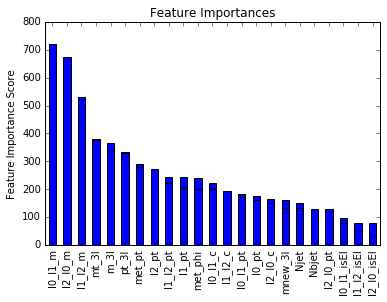

In [111]:
# xgb_1 = XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=200,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0.01,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=24)
# modelfit(xgb_1, df_1, x_cols)

xgb_0 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=5,
 min_child_weight=1,
 gamma=0.01,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=24)
modelfit(xgb_0, df_0, x_cols)

xgb_2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=5,
 min_child_weight=1,
 gamma=0.01,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=24)
modelfit(xgb_2, df_2, x_cols)

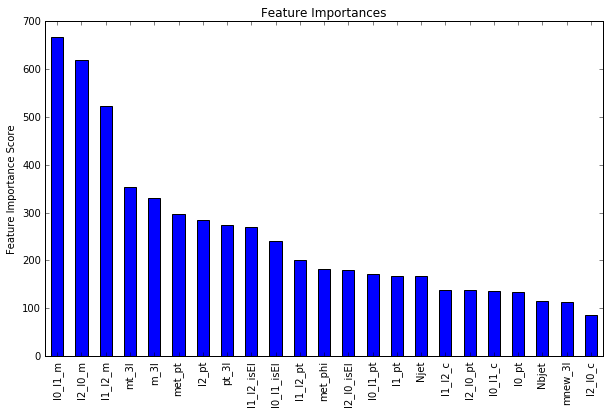

In [112]:
plt.clf()
fig = plt.figure(figsize=(10,6))
feat_imp = pd.Series(xgb_1.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.savefig('../plots/feature_ranking_1.pdf')

## Check output performance

In [41]:
model = xgb1
df_0['preds'] = model.predict_proba(df_0[x_cols])[:,1]
df_1['preds'] = model.predict_proba(df_1[x_cols])[:,1]
df_2['preds'] = model.predict_proba(df_2[x_cols])[:,1]

/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/cvmfs/sft.cern.ch/lcg/views/LCG_91python3/x86_64-slc6-gcc62-opt/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is

In [104]:
def significance(S, B):
    #return S/np.sqrt(B)
    return np.sqrt(2 * ((S + B) * np.log(1 + S / B) - S))

def check_MLoutput(df):
    plt.clf()
    x_bins = np.linspace(0, max(df.preds), 30)
    fig = plt.figure(figsize=(10,6))
    gs = gridspec.GridSpec(3, 1)
    ax = plt.subplot(gs[0,:])
    plt.title('XGBClassifier Separability')
    n_bkg,bins,paint = plt.hist(df[df.is_sig == 0].preds, bins=x_bins, weights=df[df.is_sig == 0].weight, color='r')
    plt.yscale('log')
    plt.ylabel(r'Weighted Background Counts', size=9)
    plt.legend(handles=[mpatches.Patch(color='red', label='Background')])
    ax1 = plt.subplot(gs[1,:])
    n_sig,bins,paint = plt.hist(df[df.is_sig == 1].preds, bins=x_bins, weights=df[df.is_sig == 1].weight, color='g')
    #plt.yscale('log')
    plt.ylabel(r'Weighted Signal Counts', size=9)
    plt.legend(handles=[mpatches.Patch(color='green', label='Signal')])
    ax2 = plt.subplot(gs[2,:])
    plt.bar(x_bins[:-1], significance(n_sig, n_bkg), width=x_bins[1] - x_bins[0], color='k')
    plt.ylabel(r'Significance', size=9)
    plt.xlabel('Probability Event is a Signal')

    plt.tight_layout()
    #plt.show()
    plt.savefig('../plots/preds_train.pdf')

    fpr, tpr, thresholds = metrics.roc_curve(df.is_sig.values, df.preds.values, pos_label=1)
    fig = plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr)
    plt.title('XGBClassifier ROC')
    plt.annotate('Area: ' + str(round(metrics.auc(fpr, tpr), 2)), xy=(.8,.2), xycoords='axes fraction')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.show()
    plt.savefig('../plots/roc_curve.pdf')
    print("Done!")

Done!


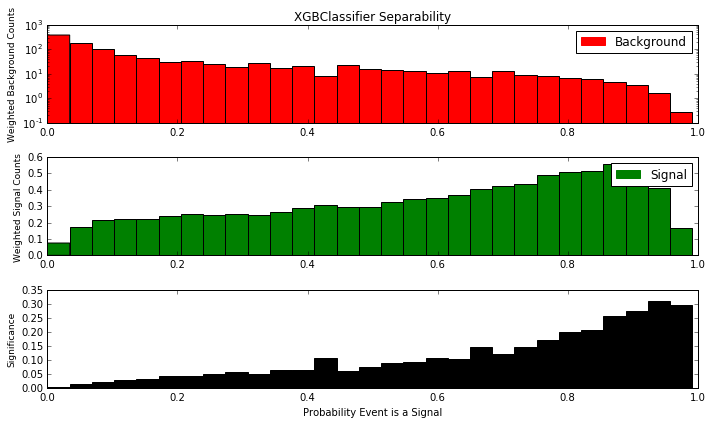

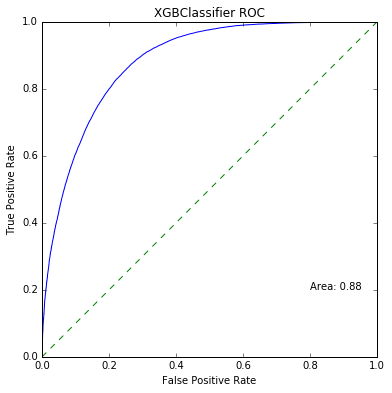

In [105]:
check_MLoutput(df_0)

Done!


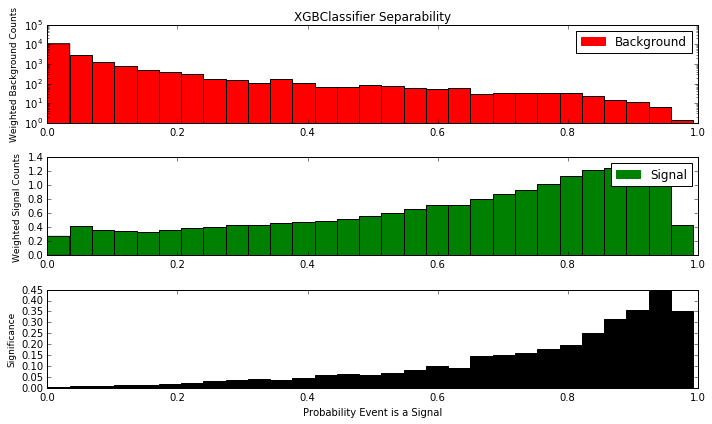

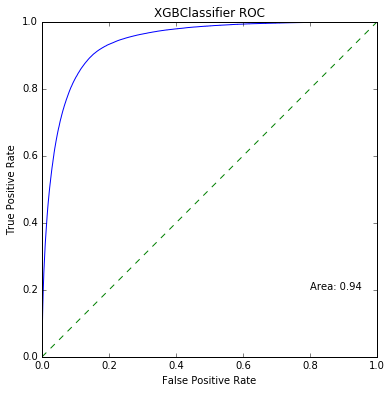

In [106]:
check_MLoutput(df_1)

Done!


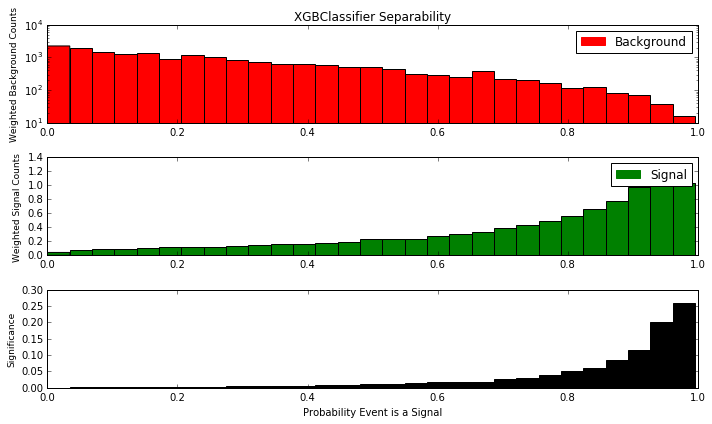

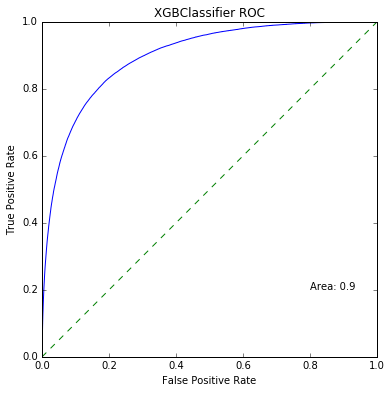

In [107]:
check_MLoutput(df_2)

100%|██████████| 23/23 [00:14<00:00,  1.56it/s]


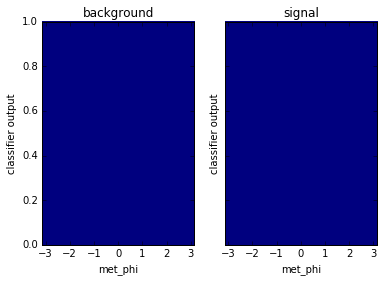

In [109]:
for var in tqdm(x_cols):
    if "_" not in var:
        continue
    if "l2_pt" in var:
        continue
    #print(var)
    colors = ['r', 'b']
    title  = {0: 'background', 1: 'signal'}
    
    plt.clf()
    f, axes = plt.subplots(1, 2, sharey=True)
    for sig in [0, 1]:        
        x = df_1[df_1['is_sig'] == sig][var]
        y = df_1[df_1['is_sig'] == sig]['preds']
        weight = df_1[df_1['is_sig'] == sig]['weight']
        #print("fill")
        if ("_m" in var):
            h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 120], [0, 1]])
        elif ("m_3l" in var):
            h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 500], [0, 1]])
        elif ("met_pt" in var):
            h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 400], [0, 1]])
        elif ("met_phi" in var):
            h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[-np.pi, np.pi], [0, 1]])
        elif ("pt" in var):
            h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 200], [0, 1]])
        elif ("mt" in var):
            h = axes[sig].hist2d(x, y, bins=[20, 10], range=[[0, 150], [0, 1]])
        else:
            h = axes[sig].hist2d(x, y, bins=[20, 16], range=[[min(x), max(x)], [0, 1]])
        axes[sig].set_ylabel('classifier output')
        axes[sig].set_xlabel(str(var))
        axes[sig].set_title(title[sig])
    plt.savefig("../plots/" + str(var) + ".pdf")